# Diabetic Retinopathy Detection Using Deep Learning

## What is Diabetic Retinopathy?
Diabetic Retinopathy is a complication of diabetes caused by high blood sugar levels damaging the back of the eye which is called the retina. The retina is a light sensitive layer of cells at the back of the eye that converts light into electrical signals the signals are sent to the brain and the Brain turns them into the images that we can see.

##### Simple Picture to Explain Diabetic Retinopathy
<div align="center">
    <img src="dr.png" alt="Figure 1: Types of lesions of diabetic retinopathy" width="500">
</div>
<p style='text-align:center'><em><b>Figure 1: Types of lesions of diabetic retinopathy.<b></em><br>
    Source: Quang Toan Dao, Hoang Quan Trinh, Viet Anh Nguyen. <a href="https://doi.org/10.7717/peerj-cs.1585/fig-1">DOI: 10.7717/peerj-cs.1585/fig-1</a></p>

From a quick data review, Hemorrhages, Hard Exudates, and Cotton Wool Spots (Soft Exudates ) are easily observed, but Aneurysms and Abnormal Blood Vessel Growth are yet to be found.

## Problem Statement
Diabetic Retinopathy (DR) is a progressively increasing eye disease and a leading cause of blindness among the working age population. Early detection and timely intervention can significantly reduce the risk of severe vision impairment. Systematic screening for DR has been recognized as a cost-effective approach to optimize healthcare resources. Automated retinal image analysis has become a promising tool for early DR detection, minimizing the reliance on manual grading while improving efficiency, reducing diagnosis costs, and saving time. In recent years, extensive research has focused on developing Deep leaning model like CNN to enhance DR detection.


## Dataset
The dataset used in this project is the APTOS 2019 Blindness Detection dataset by `Asia Pacific Tele-Ophthalmology
Society (APTOS)` which consists of retinal images labeled with five classes of diabetic retinopathy severity. The dataset is publicly available on Kaggle and contains a total of 3662 images. The images are classified into the following categories:
- 0: No DR
- 1: Mild DR
- 2: Moderate DR
- 3: Severe DR
- 4: Proliferative DR

In this project, we will build a ResNet50 model (a type of Convolutional Neural Network) to classify the images into the above categories. The model will be trained on a subset of the dataset and then evaluated on a separate test set. The goal is to achieve a high accuracy in classifying the images into the correct categories

## Importing Libraries

In [1]:
import os
import pickle
from multiprocessing.pool import ThreadPool

# Basic Libraries ..
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm import tqdm  


# metric libraries .. 
from sklearn.metrics import confusion_matrix, cohen_kappa_score,accuracy_score


# Vis Libraries ..
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Image Libraries ..
from PIL import Image
import cv2

# DeepLearning Libraries..
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dropout, Dense, Activation
from tensorflow.keras import optimizers,Model,Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import applications


# Data Loading and Exploratory Data Analysis

the first step is to load the dataset and perform some exploratory data analysis (EDA) to understand the data better

In [2]:
# This function reads data from the respective train and test directories

def load_data():
    train = pd.read_csv('dataset/train.csv')
    test = pd.read_csv('dataset/test.csv')
    
    train_dir = os.path.join('dataset/','train_images/')
    test_dir = os.path.join('dataset/','test_images/')
    
    train['file_path'] = train['id_code'].map(lambda x: os.path.join(train_dir,'{}.png'.format(x)))
    test['file_path'] = test['id_code'].map(lambda x: os.path.join(test_dir,'{}.png'.format(x)))
    
    train['file_name'] = train["id_code"].apply(lambda x: x + ".png")
    test['file_name'] = test["id_code"].apply(lambda x: x + ".png")
    
    train['diagnosis'] = train['diagnosis'].astype(str)
    
    return train,test

df_train,df_test = load_data()
print(df_train.shape,df_test.shape,'\n')
df_train.head(6)

(3662, 4) (1928, 3) 



id_code diagnosis                              file_path  \
0  000c1434d8d7         2  dataset/train_images/000c1434d8d7.png   
1  001639a390f0         4  dataset/train_images/001639a390f0.png   
2  0024cdab0c1e         1  dataset/train_images/0024cdab0c1e.png   
3  002c21358ce6         0  dataset/train_images/002c21358ce6.png   
4  005b95c28852         0  dataset/train_images/005b95c28852.png   
5  0083ee8054ee         4  dataset/train_images/0083ee8054ee.png   

          file_name  
0  000c1434d8d7.png  
1  001639a390f0.png  
2  0024cdab0c1e.png  
3  002c21358ce6.png  
4  005b95c28852.png  
5  0083ee8054ee.png

#### class distribution 

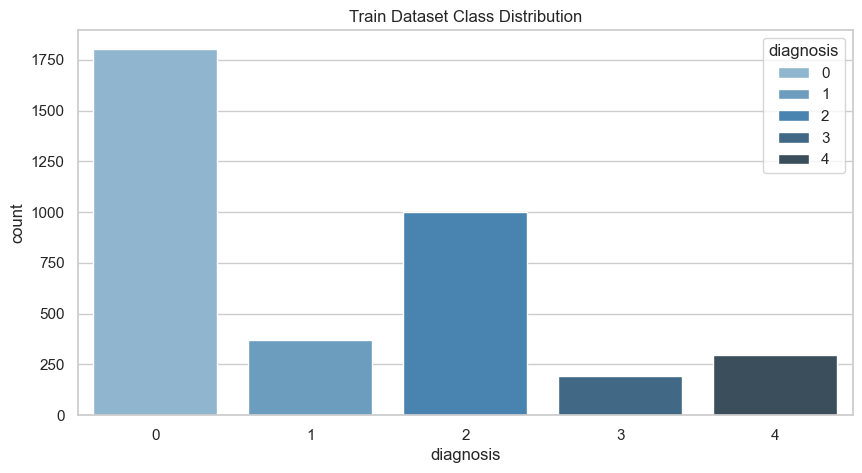

In [3]:
# Exploratory Data Analysis ..

'''This Function Plots a Bar plot of output Classes Distribution'''

def plot_classes(df):
    df_group = df.groupby('diagnosis').size().reset_index(name='count')

    sns.set(rc={'figure.figsize': (10, 5)}, style='whitegrid')
    sns.barplot(x='diagnosis', y='count', hue='diagnosis', data=df_group, palette="Blues_d", legend=True)
    plt.title('Train Dataset Class Distribution')
    plt.show()
plot_classes(df_train)


##### Plot Summary
As we can see, there is class imbalance in the output class distribution. We shall account for this while training the models using data augmentation and class weights.

### Visualize Images

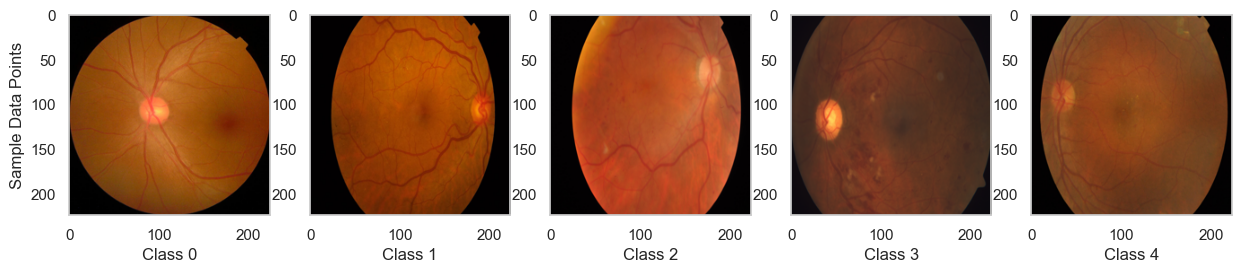

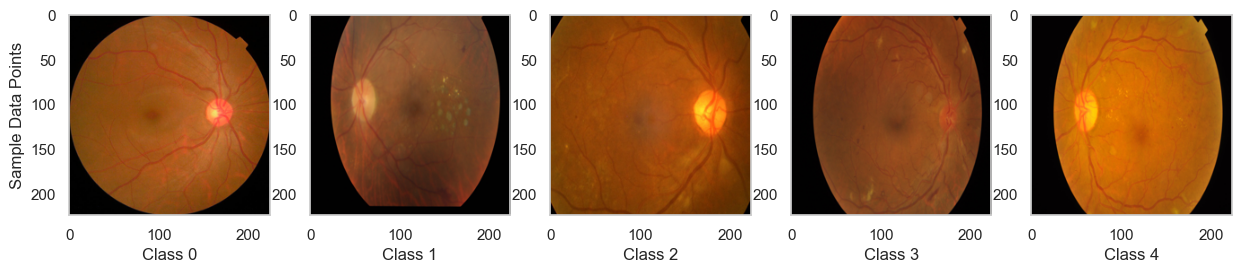

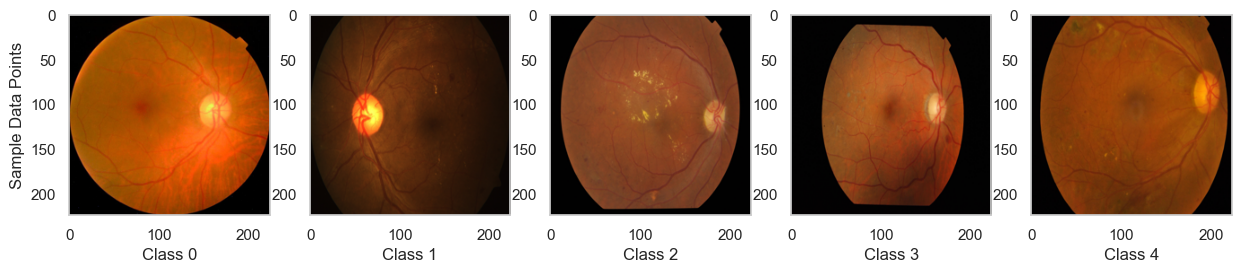

In [4]:
IMG_SIZE = 224

# This Function shows the visual Image photo of 'n x 5' points (5 of each class)

def visualize_imgs(df,pts_per_class,color_scale):
    # here pts_per_class is the number of images to be shown for each class
    # color_scale is the color scale of the image (gray or None)
    # if color_scale is None, the image will be shown in RGB format
    df = df.groupby('diagnosis',group_keys = False).apply(lambda df: df.sample(pts_per_class))
    df = df.reset_index(drop = True)
    
    plt.rcParams["axes.grid"] = False
    for pt in range(pts_per_class):
        f, axarr = plt.subplots(1,5,figsize = (15,15))
        axarr[0].set_ylabel("Sample Data Points")
        
        df_temp = df[df.index.isin([pt + (pts_per_class*0),pt + (pts_per_class*1), pt + (pts_per_class*2),pt + (pts_per_class*3),pt + (pts_per_class*4)])]
        for i in range(5):
            if color_scale == 'gray':
                img = conv_gray(cv2.imread(df_temp.file_path.iloc[i]))
                axarr[i].imshow(img,cmap = color_scale)
            else:
                axarr[i].imshow(Image.open(df_temp.file_path.iloc[i]).resize((IMG_SIZE,IMG_SIZE)))
            axarr[i].set_xlabel('Class '+str(df_temp.diagnosis.iloc[i]))

        plt.show()

# This Function converts a color image to gray scale image
def conv_gray(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
    return img
visualize_imgs(df_train,3,color_scale = None)

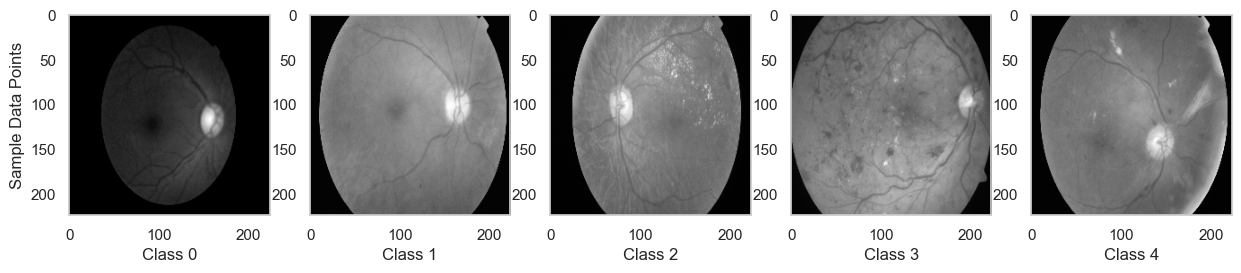

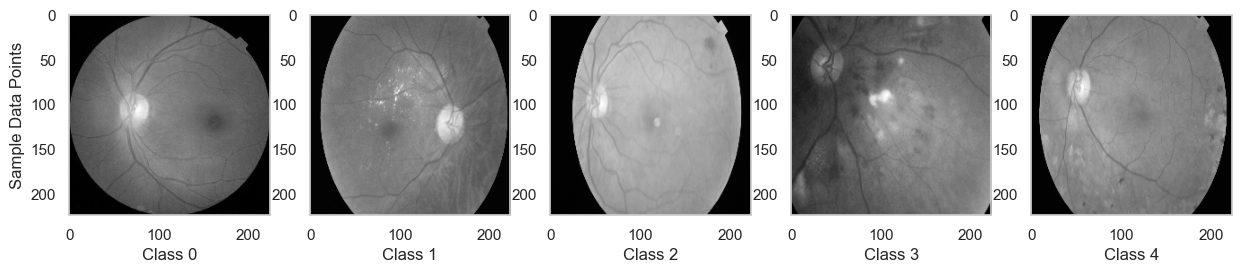

In [5]:
# This Function converts a color image to gray scale image
visualize_imgs(df_train,2,color_scale = 'gray')

#### summary 

As we can see, as we move towards higher classes, we are able to comprehend larger number of abnormalities in the eye images. Also, the lightning and brightness conditions are not even across all images. We will try to handle this using image processing techniques. Also, Gray Scale Images are giving better visualization of the eye features as compared to RGB images

### Image Processing
There are several image processing techniques that can be applied to the retinal images to enhance the features and improve the performance of the model. Some of the techniques that can be applied include:
- Gaussian Blur: is a technique used to reduce noise and smooth an image. It applies a Gaussian function to each pixel, giving more weight to nearby pixels and less weight to distant ones. The Gaussian function is given by:
$$
G(x, y) = \frac{1}{2\pi\sigma^2} \exp\left(-\frac{x^2 + y^2}{2\sigma^2}\right)
$$
where $ \sigma $ controls the amount of blur. A higher $ \sigma $ results in a smoother image.
- Histogram Equalization: This technique can be used to improve the contrast of the images. It works by redistributing the pixel values in the image to create a more uniform distribution, which enhances the visibility of features in the image.
- CLAHE (Contrast Limited Adaptive Histogram Equalization): This technique is an improvement over histogram equalization. It works by dividing the image into small regions and applying histogram equalization to each region separately, which helps to preserve the local contrast in the image.

in this notebook, we will apply the following image processing techniques to the retinal images:
1. Gaussian Blur
2. Gaussian Blur with Circular Cropping (Try Ben Graham's preprocessing method<sup>1</sup>)

<hr>
Ben Graham's the last winner of the APTOS competition (Kaggle) used a circular cropping method to remove the black borders in the images.
<hr>

### reference 
https://www.kaggle.com/ratthachat/aptos-eye-preprocessing-in-diabetic-retinopathy#3.-Further-improve-by-auto-cropping

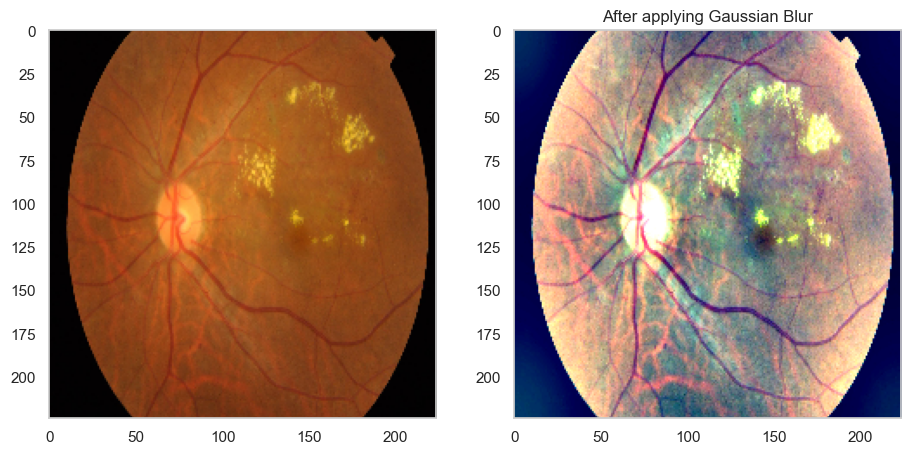

In [8]:
# 1. Gaussian Blur to a random image
rn = np.random.randint(low = 0,high = len(df_train) - 1)
img = cv2.imread(df_train.file_path.iloc[rn])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))

img_t = cv2.addWeighted(img,4, cv2.GaussianBlur(img , (0,0) , 30) ,-4 ,128)

f, axarr = plt.subplots(1,2,figsize = (11,11))
axarr[0].imshow(img)
axarr[1].imshow(img_t)
plt.title('After applying Gaussian Blur')
plt.show()

### Plot summary 
As we can see, after applying Gaussian Blur, We are able to bring out the features and image details much more clearer in the eye.

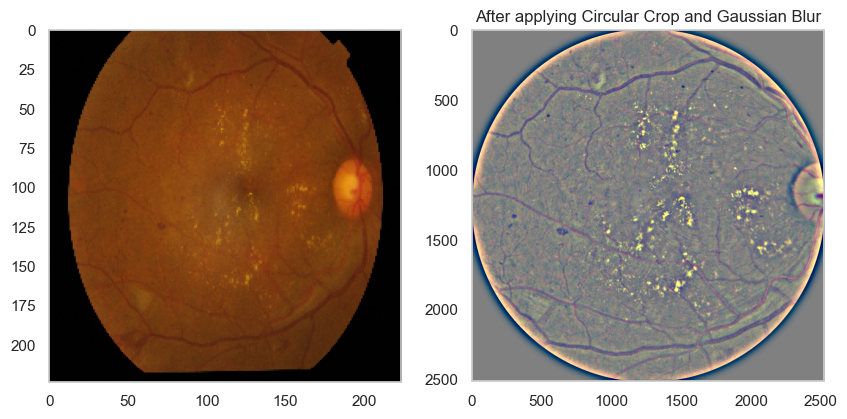

In [10]:
''' This Function performs image processing on top of images by performing Gaussian Blur and Circle Crop '''
def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
            img = np.stack([img1,img2,img3],axis=-1)
        return img  
def circle_crop(img, sigmaX):   
    
    # Create circular crop around image centre    
    img = crop_image_from_gray(img)    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    height, width, depth = img.shape    
    x = int(width/2)
    y = int(height/2)
    r = np.amin((x,y))
    circle_img = np.zeros((height, width), np.uint8)
    cv2.circle(circle_img, (x,y), int(r), 1, thickness=-1)
    img = cv2.bitwise_and(img, img, mask=circle_img)
    img = crop_image_from_gray(img)
    img=cv2.addWeighted(img,4, cv2.GaussianBlur( img , (0,0) , sigmaX) ,-4 ,128)
    return img 
    

# Perform Image Processing on a sample image
random_image = np.random.randint(low = 0,high = len(df_train) - 1)
#img = img_t
img = cv2.imread(df_train.file_path.iloc[random_image])
img_t = circle_crop(img, sigmaX=30)

plt.subplot(1, 2, 1)
plt.imshow(cv2.resize(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), (IMG_SIZE, IMG_SIZE)))

plt.subplot(1, 2, 2)
plt.imshow(img_t)
plt.title('After applying Circular Crop and Gaussian Blur')

plt.show()

##### Plot summary 
As we can see above, now the image features and details are very much clearer than what the image was before, we are ready to use this image for modelling as the image details are much more clearer

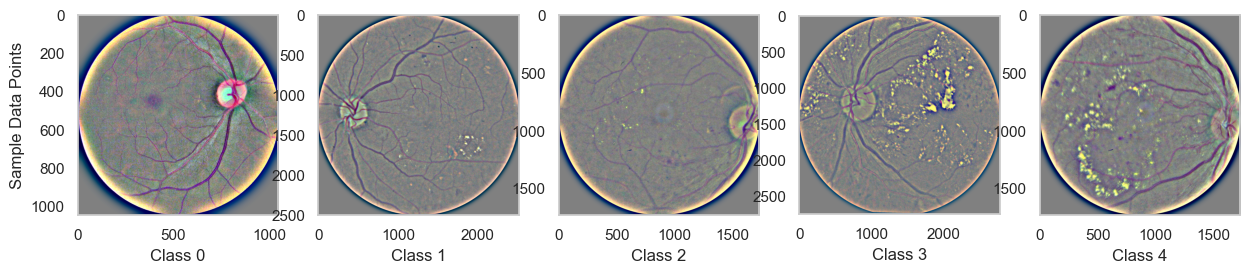

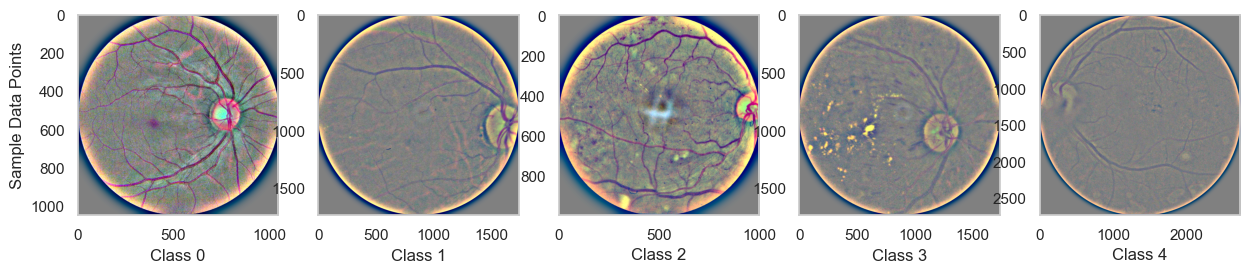

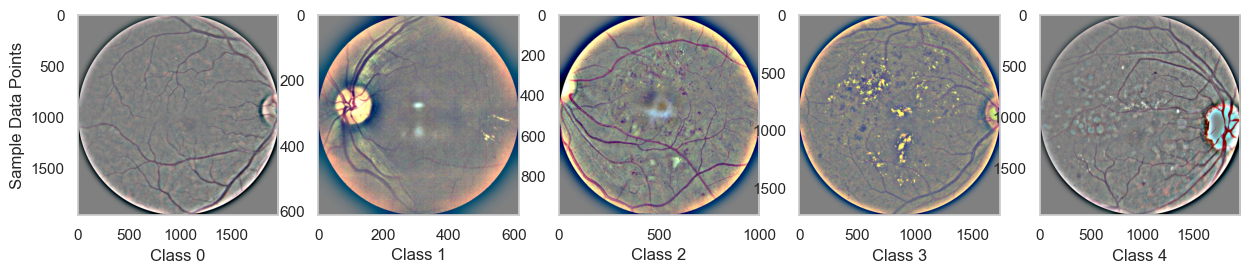

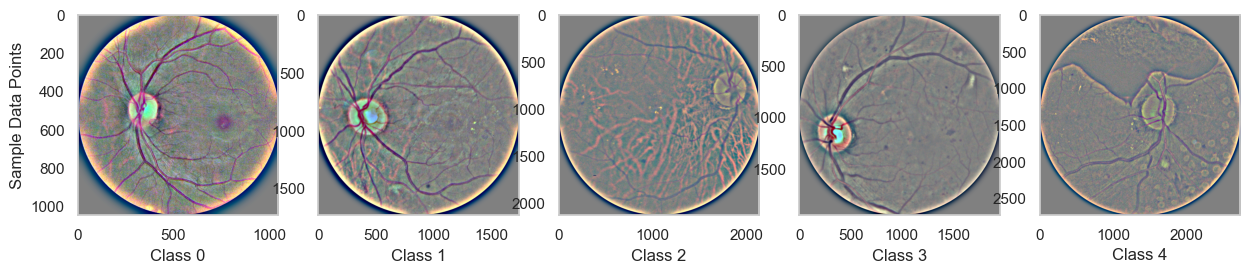

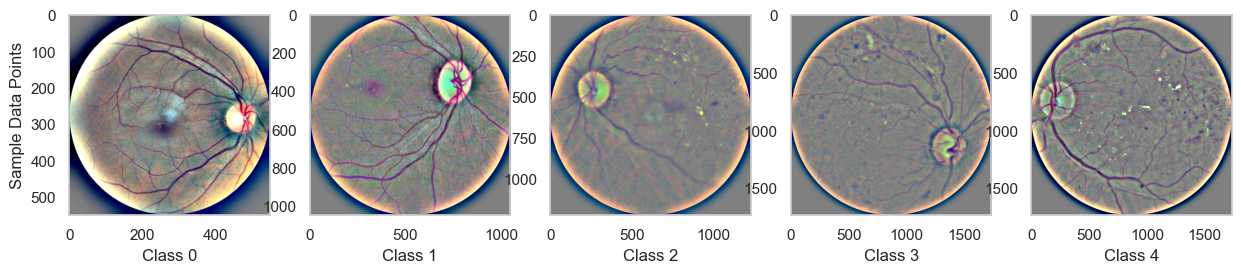

In [12]:
# This Function shows the visual Image photo of 'n x 5' points (5 of each class) and performs image processing (Gaussian Blur, Circular crop) transformation on top of that
def visualize_img_process(df,pts_per_class,sigmaX):
    df = df.groupby('diagnosis',group_keys = False).apply(lambda df: df.sample(pts_per_class))
    df = df.reset_index(drop = True)
    plt.rcParams["axes.grid"] = False
    for pt in range(pts_per_class):
        f, axarr = plt.subplots(1,5,figsize = (15,15))
        axarr[0].set_ylabel("Sample Data Points")
        
        df_temp = df[df.index.isin([pt + (pts_per_class*0),pt + (pts_per_class*1), pt + (pts_per_class*2),pt + (pts_per_class*3),pt + (pts_per_class*4)])]
        for i in range(5):
            img = cv2.imread(df_temp.file_path.iloc[i])
            img = circle_crop(img,sigmaX)
            axarr[i].imshow(img)
            axarr[i].set_xlabel('Class '+str(df_temp.diagnosis.iloc[i]))

        plt.show()
visualize_img_process(df_train,5,sigmaX = 30)


In [16]:
# The code below applies TSNE (t-distributed stochastic neighbor embedding) on Gray Scale Images - The Image is flattened to 2D Gray Image to 1D and then applies TSNE

pix = 224
X_train = np.zeros((df_train.shape[0], pix, pix))

for i in tqdm(range(df_train.shape[0])):
    img = cv2.imread(df_train.file_path.iloc[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
    X_train[i, :, :] = cv2.resize(img, (pix, pix)) 

print("X_train shape:", X_train.shape)

100%|██████████| 3662/3662 [07:35<00:00,  8.04it/s]

X_train shape: (3662, 224, 224)


In [17]:
# normalize the data
X = X_train / 255

# reshape to 1D
X = X.reshape(X.shape[0], -1)
trainy = df_train['diagnosis']

trainy = trainy.str.strip().astype(int)
# Define diagnosis mapping 
diagnosis_mapping = {
    0: "No DR",
    1: "Mild",
    2: "Moderate",
    3: "Severe",
    4: "Proliferative DR"
}

### t-SNE Visualization

**t-SNE (t-Distributed Stochastic Neighbor Embedding)** is a **dimensionality reduction technique** used to visualize **high-dimensional data** in a **2D or 3D space**. It is particularly effective for visualizing **clusters** and preserving local similarities in data.  

### How t-SNE Works  
1. Measure Similarity in High-Dimensional Space
2. Measure Similarity in Low-Dimensional Space
3. Minimize the KL Divergence Between the Two Distributions

  0%|          | 0/8 [00:00<?, ?it/s]

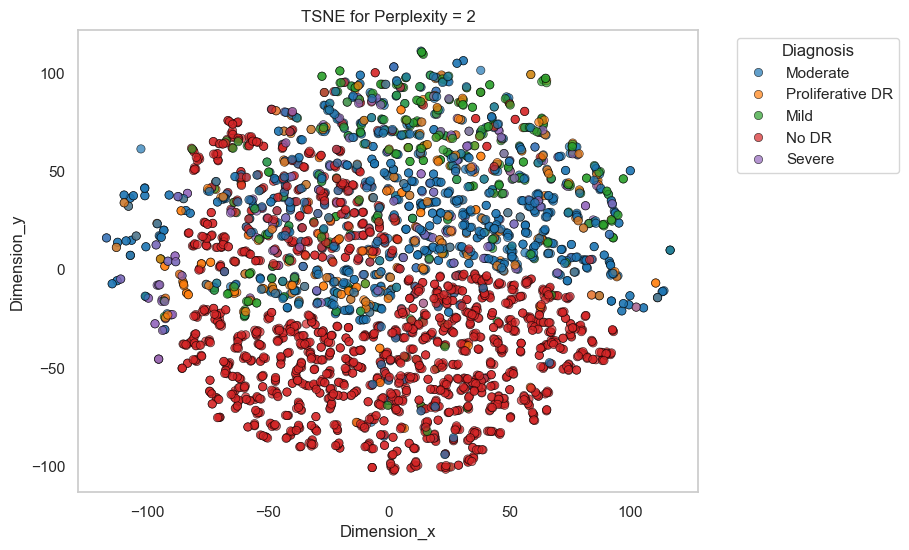

 12%|█▎        | 1/8 [00:57<06:41, 57.37s/it]

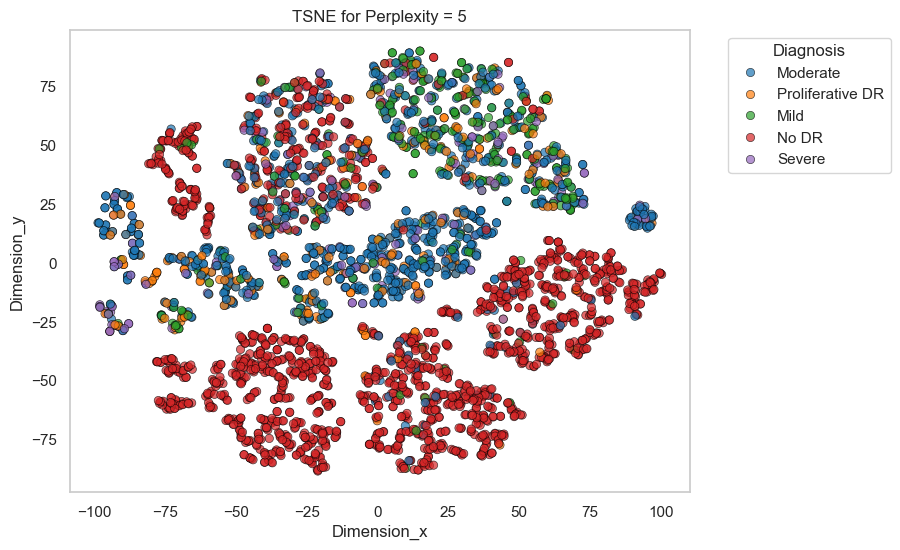

 25%|██▌       | 2/8 [01:49<05:25, 54.20s/it]

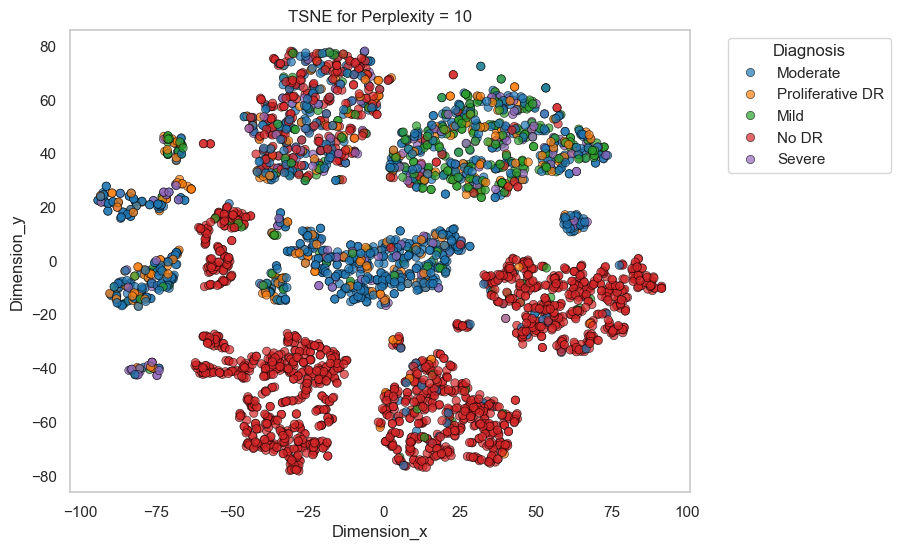

 38%|███▊      | 3/8 [02:43<04:30, 54.19s/it]

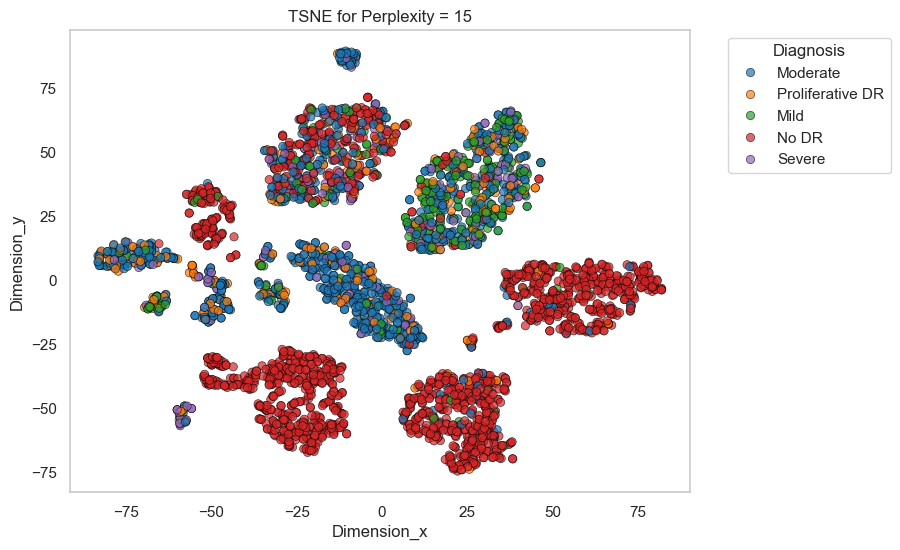

 50%|█████     | 4/8 [03:37<03:35, 53.91s/it]

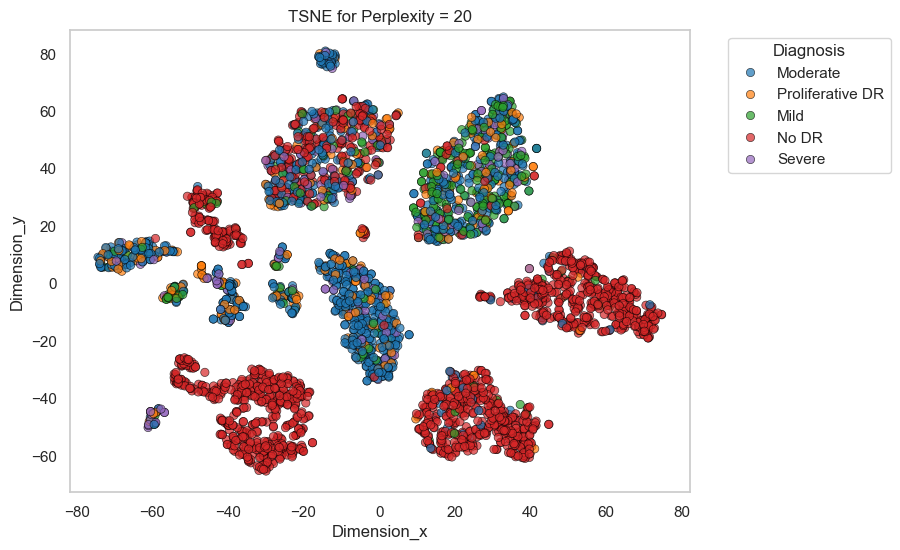

 62%|██████▎   | 5/8 [04:36<02:48, 56.02s/it]

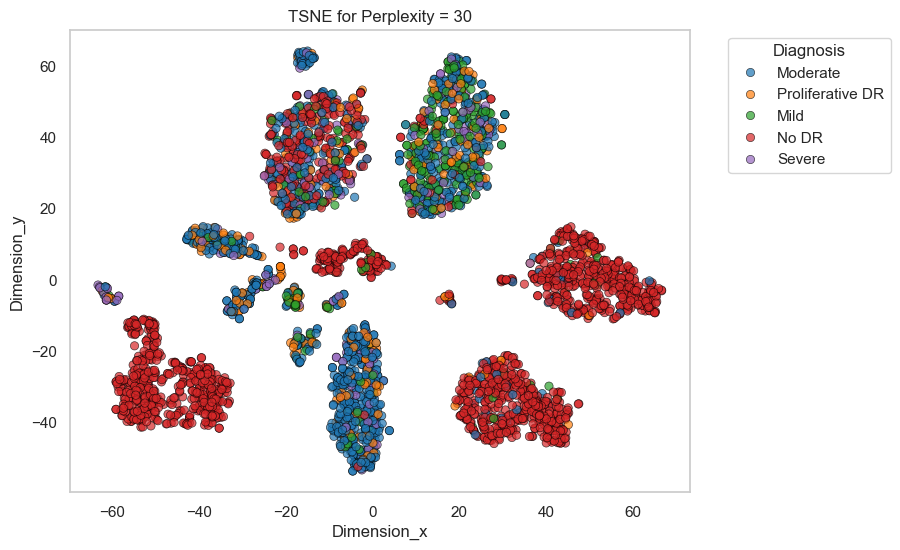

 75%|███████▌  | 6/8 [05:37<01:55, 57.59s/it]

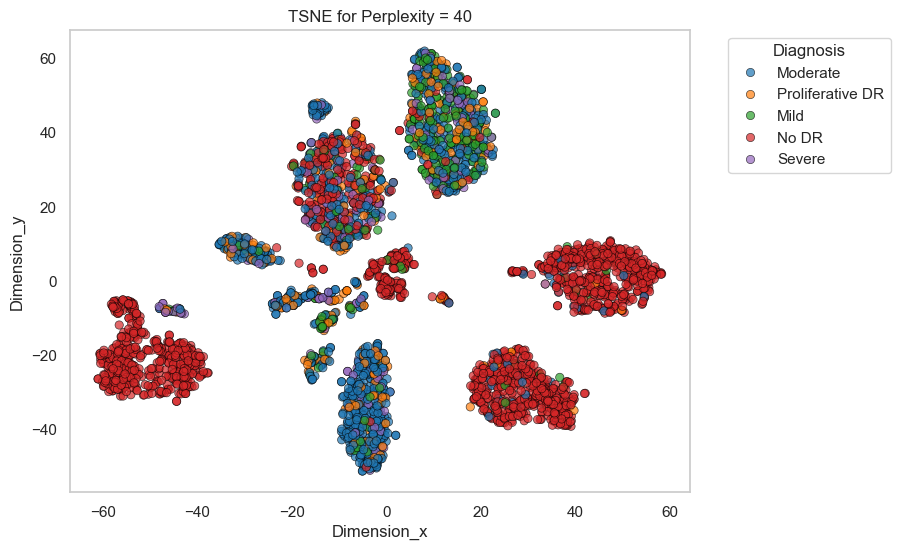

 88%|████████▊ | 7/8 [06:37<00:58, 58.53s/it]

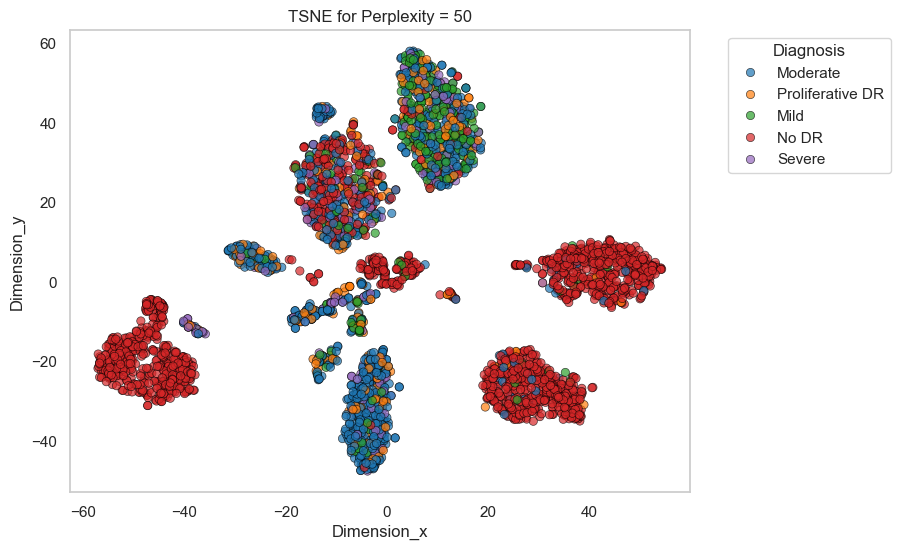

100%|██████████| 8/8 [07:44<00:00, 58.02s/it]


In [18]:
# List of perplexity values to test
per_vals = [2, 5, 10, 15, 20, 30, 40, 50]

for per in tqdm(per_vals):
    # Perform t-SNE
    X_decomposed = TSNE(n_components=2, perplexity=per, random_state=42).fit_transform(X)
    
    # Create DataFrame
    df_tsne = pd.DataFrame(X_decomposed, columns=['Dimension_x', 'Dimension_y'])
    df_tsne['Score'] = trainy.map(diagnosis_mapping)

    # Plot using seaborn scatterplot
    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=df_tsne, x='Dimension_x', y='Dimension_y', hue='Score', 
                palette='tab10', alpha=0.7, edgecolor='black')

    plt.title(f'TSNE for Perplexity = {per}')
    plt.legend(title='Diagnosis', bbox_to_anchor=(1.05, 1), loc='upper left')  
    plt.show()

## summary 
As we can see, we are able to seperate Class 0: No DR from other classes (1-4). Seperating between classes 1-4 looks challenging.

## Data Augmentation

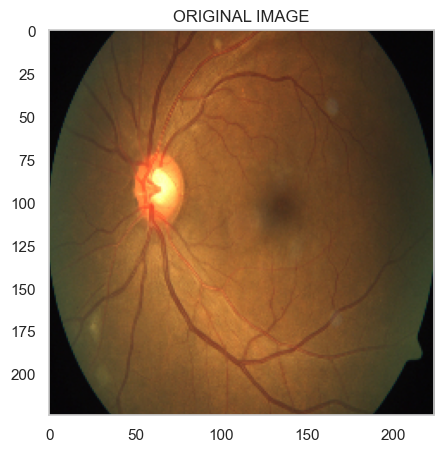

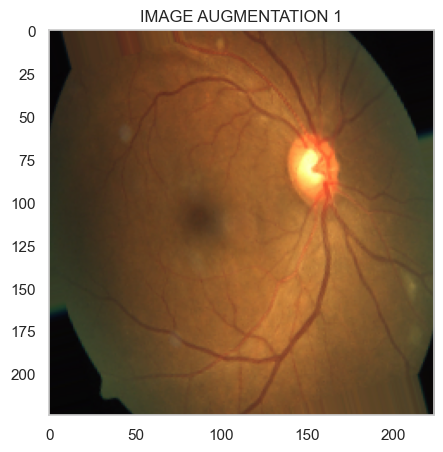

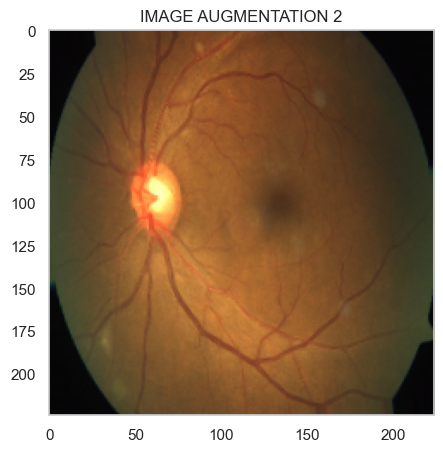

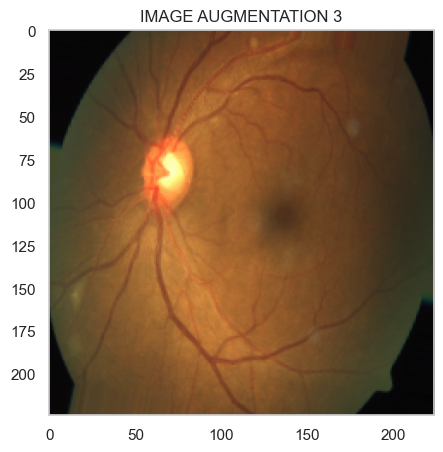

In [15]:
'''This Function generates 'lim' number of Image Augmentations from a random Image in the directory'''

def generate_augmentations(lim):
    datagen = ImageDataGenerator(featurewise_center=True,
                                 featurewise_std_normalization=True,
                                 rotation_range=20,
                                 #width_shift_range=0.2,
                                 #height_shift_range=0.2,
                                 horizontal_flip=True)
    img = cv2.imread(df_train.file_path.iloc[np.random.randint(low = 0,high = len(df_train) - 1)])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
    plt.imshow(img)
    plt.title('ORIGINAL IMAGE')
    plt.show()
    
    img_arr = img.reshape((1,) + img.shape)
    
    i = 0
    for img_iterator in datagen.flow(x = img_arr,batch_size = 1):
        i = i + 1
        if i > lim:
            break
        plt.imshow((img_iterator.reshape(img_arr[0].shape)).astype(np.uint8))
        plt.title('IMAGE AUGMENTATION ' + str(i))
        plt.show() 
generate_augmentations(3)

#### Summary
As we can see above, Image Augmentations are extremely helpful for this datasets to make our Models more robust and generalize better

### Preprocessing
In this section, we will preprocess the images before feeding them into the model. The preprocessing steps include:
- Splitting the dataset into training, and test sets (80% training and 20% testing) 
- save the dataframes to pickle files for future use
- Resizing the images to 224x224 pixels and saving them in a new directory (`resized_images`)
- apply gaussian blur and circular cropping to the images and saving them in a new directory (`resized_processed_images`)


In [20]:
# splitting train dataset into train and val
df_train_train,df_train_test = train_test_split(df_train,test_size = 0.2)

print(df_train_train.shape,df_train_test.shape)

# Save the dataframes to pickle files for later use
file = open('df_train_train', 'wb')
pickle.dump(df_train_train, file)
file.close()

file = open('df_train_test', 'wb')
pickle.dump(df_train_test, file)
file.close()

(2929, 4) (733, 4)


In [21]:
# Loading the train and test data from the pickle files
file = open('df_train_train', 'rb')
df_train_train = pickle.load(file)
file.close()

file = open('df_train_test', 'rb')
df_train_test = pickle.load(file)
file.close()

df_train_train.shape, df_train_test.shape

((2929, 4), (733, 4))

In [ ]:
'''Function loads an image from Folder , Resizes and saves in another directory '''
# for train df
def image_resize_save(file):
    input_filepath = f'dataset/train_images/{file}.png'
    output_dir = 'dataset/train_images_resized'
    output_filepath = f'{output_dir}/{file}.png'

    os.makedirs(output_dir, exist_ok=True) 

    img = cv2.imread(input_filepath)
    if img is not None:
        cv2.imwrite(output_filepath, cv2.resize(img, (IMG_SIZE, IMG_SIZE)))
    else:
        print(f"Error: Image '{file}.png' not found.")
#image_resize_save(df_train_train.id_code.iloc[201])

'''This Function uses Multi processing for faster saving of images into folder'''

def multiprocess_image_downloader(process:int, imgs:list):
    """
    Inputs:
        process: (int) number of process to run
        imgs:(list) list of images
    """
    print(f'MESSAGE: Running {process} process')
    results = ThreadPool(process).map(image_resize_save, imgs)
    return results

multiprocess_image_downloader(4, list(df_train_train.id_code.values))

In [ ]:
# for test df
def image_resize_save(file):
    input_filepath = f'dataset/train_images/{file}.png'
    output_dir = 'dataset/test_images_resized'
    output_filepath = f'{output_dir}/{file}.png'

    os.makedirs(output_dir, exist_ok=True) 

    img = cv2.imread(input_filepath)
    if img is not None:
        cv2.imwrite(output_filepath, cv2.resize(img, (IMG_SIZE, IMG_SIZE)))
    else:
        print(f"Error: Image '{file}.png' not found.")
multiprocess_image_downloader(4, list(df_train_test.id_code.values))

In [ ]:
def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
    #         print(img1.shape,img2.shape,img3.shape)
            img = np.stack([img1,img2,img3],axis=-1)
    #         print(img.shape)
        return img

def circle_crop(img, sigmaX = 30):   
    """
    Create circular crop around image centre    
    """    
    img = crop_image_from_gray(img)    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    height, width, depth = img.shape    
    x = int(width/2)
    y = int(height/2)
    r = np.amin((x,y))
    circle_img = np.zeros((height, width), np.uint8)
    cv2.circle(circle_img, (x,y), int(r), 1, thickness=-1)
    img = cv2.bitwise_and(img, img, mask=circle_img)
    img = crop_image_from_gray(img)
    img=cv2.addWeighted(img,4, cv2.GaussianBlur( img , (0,0) , sigmaX) ,-4 ,128)
    return img 

def preprocess_image(file):
    input_filepath = f'dataset/train_images_resized/{file}.png'
    output_dir = 'dataset/train_images_resized_preprocessed'
    output_filepath = f'{output_dir}/{file}.png'
    os.makedirs(output_dir, exist_ok=True) 
    img = cv2.imread(input_filepath)
    img = circle_crop(img) 
    cv2.imwrite(output_filepath, cv2.resize(img, (IMG_SIZE,IMG_SIZE)))
'''This Function uses Multi processing for faster saving of images into folder'''

def multiprocess_image_processor(process:int, imgs:list):
    """
    Inputs:
        process: (int) number of process to run
        imgs:(list) list of images
    """
    print(f'MESSAGE: Running {process} process')
    results = ThreadPool(process).map(preprocess_image, imgs)
    return results
#preprocess_image(df_train_train.id_code.iloc[201])
multiprocess_image_processor(4, list(df_train_train.id_code.values))

In [ ]:
def preprocess_image(file):
    input_filepath = f'dataset/test_images_resized/{file}.png'
    output_dir = 'dataset/test_images_resized_preprocessed'
    output_filepath = f'{output_dir}/{file}.png'
    os.makedirs(output_dir, exist_ok=True) 
    img = cv2.imread(input_filepath)
    img = circle_crop(img) 
    cv2.imwrite(output_filepath, cv2.resize(img, (IMG_SIZE,IMG_SIZE)))
multiprocess_image_processor(4, list(df_train_test.id_code.values))

## Training
In this section, we will train the model using the preprocessed images. We will use the following steps to train the model:
1. Load the preprocessed images from the directory (`resized_processed_images`)
2. Create a data generator to load the images in batches and apply data augmentation techniques such as rotation, zoom, and horizontal flip.
3. Define the model architecture using a pre-trained ResNet50 model with transfer learning.
4. Compile the model using the Adam optimizer and categorical crossentropy loss function.
5. Train the model using the training set and validate it using the validation set.

## Model Architecture 
<img src='model-architecture.jpeg'>

In [44]:
# Model parameters
BATCH_SIZE = 8
EPOCHS = 40
WARMUP_EPOCHS = 2
LEARNING_RATE = 1e-4
WARMUP_LEARNING_RATE = 1e-3
HEIGHT = 224
WIDTH = 224
CANAL = 3
N_CLASSES = df_train_train['diagnosis'].nunique()
ES_PATIENCE = 5
RLROP_PATIENCE = 3
DECAY_DROP = 0.5

In [45]:
def img_generator(train, test):
    # Define the base augmentation strategy
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=0.2,
        # Geometric Augmentations (Preserve DR features)
        horizontal_flip=True,  # Flip horizontally (common for DR)
        rotation_range=10,  # Limit rotation to 10° to avoid unnatural views
        width_shift_range=0.05,  # Smaller horizontal shifts to avoid cutting lesions
        height_shift_range=0.05,  # Smaller vertical shifts to avoid cutting lesions
        
        # Photometric Augmentations (Simulate lighting and camera variations)
        brightness_range=[0.9, 1.1],  # Slight brightness adjustments to simulate lighting differences
        shear_range=0.05,  # Reduce shear to avoid excessive distortion
        zoom_range=0.1,  # Small zoom to simulate lens zooming
        fill_mode="nearest"  # Nearest pixel filling to minimize unnatural results
    ) 
    # Creating an augmented training set, balancing the dataset
    train_generator = train_datagen.flow_from_dataframe(
        dataframe=df_train_train,
        directory="./dataset/train_images_resized_preprocessed/",
        x_col="file_name",
        y_col="diagnosis",
        batch_size=BATCH_SIZE,
        class_mode="categorical",
        target_size=(HEIGHT, WIDTH),
        subset='training'
    )

    # Validation data (no augmentation applied)
    valid_generator = train_datagen.flow_from_dataframe(
        dataframe=df_train_train,
        directory="./dataset/train_images_resized_preprocessed/",
        x_col="file_name",
        y_col="diagnosis",
        batch_size=BATCH_SIZE,
        class_mode="categorical",
        target_size=(HEIGHT, WIDTH),
        subset='validation'
    )

    # Test data generator (only rescaling, no augmentation)
    test_datagen = ImageDataGenerator(rescale=1./255)
    test_generator = test_datagen.flow_from_dataframe(
        dataframe=df_train_test,
        directory="./dataset/test_images_resized_preprocessed/",
        x_col="file_name",
        y_col="diagnosis",
        batch_size=1,
        shuffle=False,
        class_mode="categorical",
        target_size=(HEIGHT, WIDTH)
    )

    return train_generator, valid_generator, test_generator

train_generator,valid_generator,test_generator = img_generator(df_train_train,df_train_test)


Found 2344 validated image filenames belonging to 5 classes.
Found 585 validated image filenames belonging to 5 classes.
Found 733 validated image filenames belonging to 5 classes.


### ResNet50 Models

In [48]:
def create_model(input_shape, n_out):
    input_tensor = Input(shape=input_shape)
    base_model = applications.ResNet50(weights="imagenet", include_top=False, input_tensor=input_tensor)


    x = GlobalAveragePooling2D()(base_model.output)
    x = Dropout(0.5)(x)
    x = Dense(2048, activation='relu')(x)
    x = Dropout(0.5)(x)
    final_output = Dense(n_out, activation='softmax', name='final_output')(x)
    model = Model(input_tensor, final_output)
    return model

model = create_model(input_shape=(HEIGHT, WIDTH, CANAL), n_out=N_CLASSES)

for layer in model.layers:
    layer.trainable = False

for i in range(-5, 0):
    model.layers[i].trainable = True
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 320, 320,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 326, 326,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 160, 160,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 160, 160,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 160, 160,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 162, 162,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 80, 80,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 80, 80,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 80, 80,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 80, 80,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 80, 80,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 80, 80,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 80, 80,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 80, 80,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 80, 80,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 80, 80,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 80, 80,    │      1,024 │ conv2_block1_3_c

 Total params: 27,794,309 (106.03 MB)

 Trainable params: 4,206,597 (16.05 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [49]:
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size
print(STEP_SIZE_TRAIN,STEP_SIZE_VALID)

293 73


In [50]:
optimizer = optimizers.Adam(learning_rate=WARMUP_LEARNING_RATE)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

history_warmup = model.fit(
    train_generator,
    steps_per_epoch=STEP_SIZE_TRAIN,
    validation_data=valid_generator,
    validation_steps=STEP_SIZE_VALID,
    epochs=WARMUP_EPOCHS,
    verbose=1
).history



c:\Users\muhd\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/2
293/293 ━━━━━━━━━━━━━━━━━━━━ 514s 2s/step - accuracy: 0.3435 - loss: 2.6291 - val_accuracy: 0.4743 - val_loss: 1.2590
Epoch 2/2
293/293 ━━━━━━━━━━━━━━━━━━━━ 476s 2s/step - accuracy: 0.4667 - loss: 1.3786 - val_accuracy: 0.4760 - val_loss: 1.2658


In [51]:
for layer in model.layers:
    layer.trainable = True

es = EarlyStopping(monitor='val_loss', mode='min', patience=ES_PATIENCE, restore_best_weights=True, verbose=1)
rlrop = ReduceLROnPlateau(monitor='val_loss', mode='min', patience=RLROP_PATIENCE, factor=DECAY_DROP, min_lr=1e-6, verbose=1)

callback_list = [es, rlrop]
optimizer = optimizers.Adam(learning_rate=LEARNING_RATE)
model.compile(optimizer=optimizer, loss="binary_crossentropy",  metrics=['accuracy'])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 320, 320,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 326, 326,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 160, 160,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 160, 160,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 160, 160,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 162, 162,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 80, 80,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 80, 80,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 80, 80,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 80, 80,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 80, 80,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 80, 80,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 80, 80,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 80, 80,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 80, 80,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 80, 80,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 80, 80,    │      1,024 │ conv2_block1_3_c

 Total params: 27,794,309 (106.03 MB)

 Trainable params: 27,741,189 (105.82 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [52]:
history_finetuning = model.fit(
    train_generator,
    steps_per_epoch=STEP_SIZE_TRAIN,
    validation_data=valid_generator,
    validation_steps=STEP_SIZE_VALID,
    epochs=EPOCHS,
    callbacks=callback_list,
   # class_weight=class_weight_dict,
    verbose=1
).history


Epoch 1/40
293/293 ━━━━━━━━━━━━━━━━━━━━ 1683s 6s/step - accuracy: 0.6001 - loss: 0.5033 - val_accuracy: 0.4743 - val_loss: 0.5097 - learning_rate: 1.0000e-04
Epoch 2/40
293/293 ━━━━━━━━━━━━━━━━━━━━ 1593s 5s/step - accuracy: 0.7331 - loss: 0.2447 - val_accuracy: 0.4914 - val_loss: 0.4574 - learning_rate: 1.0000e-04
Epoch 3/40
293/293 ━━━━━━━━━━━━━━━━━━━━ 1592s 5s/step - accuracy: 0.7623 - loss: 0.2131 - val_accuracy: 0.7414 - val_loss: 0.2682 - learning_rate: 1.0000e-04
Epoch 4/40
293/293 ━━━━━━━━━━━━━━━━━━━━ 1600s 5s/step - accuracy: 0.7749 - loss: 0.1971 - val_accuracy: 0.7962 - val_loss: 0.2350 - learning_rate: 1.0000e-04
Epoch 5/40
293/293 ━━━━━━━━━━━━━━━━━━━━ 1660s 6s/step - accuracy: 0.7901 - loss: 0.1928 - val_accuracy: 0.7962 - val_loss: 0.2393 - learning_rate: 1.0000e-04
Epoch 6/40
293/293 ━━━━━━━━━━━━━━━━━━━━ 1677s 6s/step - accuracy: 0.8176 - loss: 0.1718 - val_accuracy: 0.7432 - val_loss: 0.2483 - learning_rate: 1.0000e-04
Epoch 7/40
293/293 ━━━━━━━━━━━━━━━━━━━━ 1667s 6s/ste

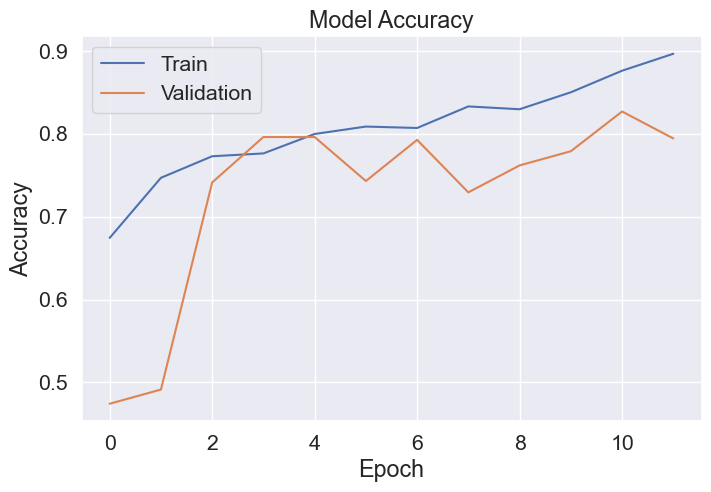

In [53]:
plt.figure(figsize=(8,5))

plt.plot(history_finetuning['accuracy'])
plt.plot(history_finetuning['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.gca().ticklabel_format(axis='both', style='plain', useOffset=False)
plt.show()

In [54]:
# Generate Train Predictions on Complete Train Data
complete_datagen = ImageDataGenerator(rescale=1.0 / 255)
complete_generator = complete_datagen.flow_from_dataframe(
    dataframe=df_train_train,
    directory="./dataset/train_images_resized_preprocessed/",
    x_col="file_name",
    target_size=(HEIGHT, WIDTH),
    batch_size=1,
    shuffle=False,
    class_mode=None
)

STEP_SIZE_COMPLETE = complete_generator.n // complete_generator.batch_size

train_preds = model.predict(complete_generator, steps=STEP_SIZE_COMPLETE, verbose=1)
train_preds = [np.argmax(pred) for pred in train_preds]


Found 2929 validated image filenames.
2929/2929 ━━━━━━━━━━━━━━━━━━━━ 560s 190ms/step


In [55]:
print("Train Cohen Kappa score: %.3f" % cohen_kappa_score(train_preds, df_train_train['diagnosis'].astype('int'), weights='quadratic'))
print("Train Accuracy score : %.3f" % accuracy_score(df_train_train['diagnosis'].astype('int'),train_preds))

Train Cohen Kappa score: 0.849
Train Accuracy score : 0.818


## Evaluate Model on Test Data 


In [56]:
test_generator.reset()
STEP_SIZE_TEST = test_generator.n // test_generator.batch_size

test_preds = model.predict(test_generator, steps=STEP_SIZE_TEST, verbose=1)
test_labels = [np.argmax(pred) for pred in test_preds]


c:\Users\muhd\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


733/733 ━━━━━━━━━━━━━━━━━━━━ 138s 184ms/step


In [57]:
def plot_conf_matrix(true,pred,classes):
    cf = confusion_matrix(true, pred)
    
    df_cm = pd.DataFrame(cf, range(len(classes)), range(len(classes)))
    plt.figure(figsize=(8,5.5))
    sns.set(font_scale=1.4)
    sns.heatmap(df_cm, annot=True, annot_kws={"size": 16},xticklabels = classes ,yticklabels = classes,fmt='g')
    plt.show()

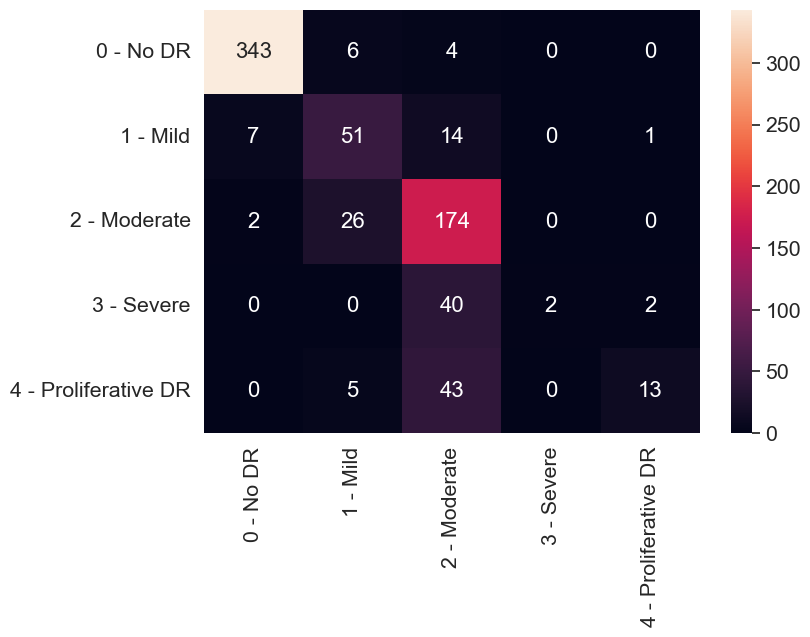

In [58]:
labels = ['0 - No DR', '1 - Mild', '2 - Moderate', '3 - Severe', '4 - Proliferative DR']
plot_conf_matrix(list(df_train_test['diagnosis'].astype(int)),test_labels,labels)

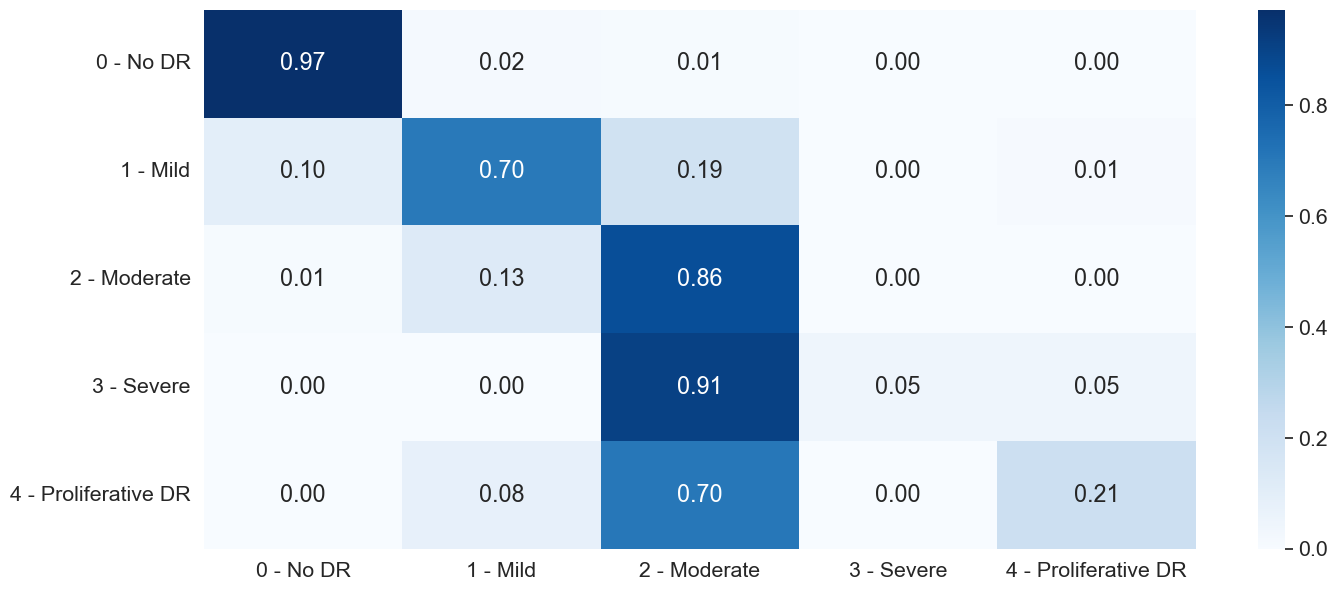

In [59]:
cnf_matrix = confusion_matrix(df_train_test['diagnosis'].astype('int'), test_labels)
cnf_matrix_norm = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(cnf_matrix_norm, index=labels, columns=labels)
plt.figure(figsize=(16, 7))
sns.heatmap(df_cm, annot=True, fmt='.2f', cmap="Blues")
plt.show()

In [60]:
print("Test Cohen Kappa score: %.3f" % cohen_kappa_score(test_labels, df_train_test['diagnosis'].astype('int'), weights='quadratic'))
print("Test Accuracy score : %.3f" % accuracy_score(df_train_test['diagnosis'].astype('int'),test_labels))

Test Cohen Kappa score: 0.833
Test Accuracy score : 0.795


### References
1. Athira, T. R., & Nair, J. J. (2023). *Diabetic Retinopathy Grading From Color Fundus Images: An Autotuned Deep Learning Approach.* Procedia Computer Science, 218, 1055–1066. https://doi.org/10.1016/j.procs.2023.01.085
2. Dao, Q. T., Trinh, H. Q., & Nguyen, V. A. (2023). *An effective and comprehensible method to detect and evaluate retinal damage due to diabetes complications.* PeerJ Computer Science, 9, e1585. https://doi.org/10.7717/peerj-cs.1585
3. Google Research. (2016, November 29). *Deep learning for detection of diabetic eye disease.* Google Research Blog. https://research.google/blog/deep-learning-for-detection-of-diabetic-eye-disease/
4. Kaggle. (2019). *APTOS 2019 blindness detection.* Kaggle. https://www.kaggle.com/c/aptos2019-blindness-detection
 
